<a href="https://colab.research.google.com/github/dmnchv/pic-text/blob/main/pic_text.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Прекод

# Сборный проект-4

Вам поручено разработать демонстрационную версию поиска изображений по запросу.

Для демонстрационной версии нужно обучить модель, которая получит векторное представление изображения, векторное представление текста, а на выходе выдаст число от 0 до 1 — покажет, насколько текст и картинка подходят друг другу.

### Описание данных

Данные доступны по [ссылке](https://code.s3.yandex.net/datasets/dsplus_integrated_project_4.zip).

В файле `train_dataset.csv` находится информация, необходимая для обучения: имя файла изображения, идентификатор описания и текст описания. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат `<имя файла изображения>#<порядковый номер описания>`.

В папке `train_images` содержатся изображения для тренировки модели.

В файле `CrowdAnnotations.tsv` — данные по соответствию изображения и описания, полученные с помощью краудсорсинга. Номера колонок и соответствующий тип данных:

1. Имя файла изображения.
2. Идентификатор описания.
3. Доля людей, подтвердивших, что описание соответствует изображению.
4. Количество человек, подтвердивших, что описание соответствует изображению.
5. Количество человек, подтвердивших, что описание не соответствует изображению.

В файле `ExpertAnnotations.tsv` содержатся данные по соответствию изображения и описания, полученные в результате опроса экспертов. Номера колонок и соответствующий тип данных:

1. Имя файла изображения.
2. Идентификатор описания.

3, 4, 5 — оценки трёх экспертов.

Эксперты ставят оценки по шкале от 1 до 4, где 1 — изображение и запрос совершенно не соответствуют друг другу, 2 — запрос содержит элементы описания изображения, но в целом запрос тексту не соответствует, 3 — запрос и текст соответствуют с точностью до некоторых деталей, 4 — запрос и текст соответствуют полностью.

В файле `test_queries.csv` находится информация, необходимая для тестирования: идентификатор запроса, текст запроса и релевантное изображение. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат `<имя файла изображения>#<порядковый номер описания>`.

В папке `test_images` содержатся изображения для тестирования модели.

In [2]:
#загружаем словарь для лемматизации текста
!python -m spacy download en_core_web_md

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.5/33.5 MB 37.6 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [113]:
#Загружаем необходимые библиотеки

#библиотеки для работы с данными
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.image as mpimg
import random
#библиотеки для работы с текстом
import spacy
import en_core_web_md
from sklearn.feature_extraction.text import TfidfVectorizer

#работа с изображениями
import os
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image

#подготовка модели
from sklearn.model_selection import GroupShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer


#модели
from sklearn.linear_model import LinearRegression
from sklearn.svm import LinearSVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.dummy import DummyRegressor
from lightgbm import LGBMRegressor

#настройка моделей
from sklearn.model_selection import GridSearchCV

#метрика
from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import mean_squared_error

#работа с нейронной сетью
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import ReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import RootMeanSquaredError

In [4]:
#передаем словарь в переменную nlp
nlp = en_core_web_md.load()

Загружаем архив с данными. Распаковываем архив. Загружаем данные.

In [5]:
!wget https://code.s3.yandex.net/datasets/dsplus_integrated_project_4.zip

--2025-05-06 09:12:17--  https://code.s3.yandex.net/datasets/dsplus_integrated_project_4.zip
Resolving code.s3.yandex.net (code.s3.yandex.net)... 93.158.134.158, 2a02:6b8::2:158
Connecting to code.s3.yandex.net (code.s3.yandex.net)|93.158.134.158|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 150987455 (144M) [application/zip]
Saving to: ‘dsplus_integrated_project_4.zip’

dsplus_integrated_p 100%[===================>] 143.99M  4.94MB/s    in 28s     

2025-05-06 09:12:47 (5.20 MB/s) - ‘dsplus_integrated_project_4.zip’ saved [150987455/150987455]



In [6]:
!unzip -q dsplus_integrated_project_4.zip -d dataset/

In [7]:
train_df = pd.read_csv("dataset/to_upload/train_dataset.csv")
crowd_annotation = pd.read_csv("dataset/to_upload/CrowdAnnotations.tsv", sep='\t', header=None)
crowd_annotation.columns=[
    'image',
    'query_id',
    'possitive_part',
    'possitive_number',
    'negative_number'
]
expert_annotation = pd.read_csv("dataset/to_upload/ExpertAnnotations.tsv", sep='\t', header=None)
expert_annotation.columns=[
    'image',
    'query_id',
    'expert_1',
    'expert_2',
    'expert_3'
]
test_df = pd.read_csv("dataset/to_upload/test_queries.csv", sep='|')

## Первичное исследование загруженных данных

In [8]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image       5822 non-null   object
 1   query_id    5822 non-null   object
 2   query_text  5822 non-null   object
dtypes: object(3)
memory usage: 136.6+ KB


In [9]:
train_df.head()

,image,query_id,query_text
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
1,1262583859_653f1469a9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
2,2447284966_d6bbdb4b6e.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
3,2549968784_39bfbe44f9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
4,2621415349_ef1a7e73be.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...


В таблице train_df 5822 строки, пропущенных значений нет.

In [10]:
crowd_annotation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47830 entries, 0 to 47829
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   image             47830 non-null  object 
 1   query_id          47830 non-null  object 
 2   possitive_part    47830 non-null  float64
 3   possitive_number  47830 non-null  int64  
 4   negative_number   47830 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 1.8+ MB


In [11]:
crowd_annotation.head()

,image,query_id,possitive_part,possitive_number,negative_number
0,1056338697_4f7d7ce270.jpg,1056338697_4f7d7ce270.jpg#2,1.0,3,0
1,1056338697_4f7d7ce270.jpg,114051287_dd85625a04.jpg#2,0.0,0,3
2,1056338697_4f7d7ce270.jpg,1427391496_ea512cbe7f.jpg#2,0.0,0,3
3,1056338697_4f7d7ce270.jpg,2073964624_52da3a0fc4.jpg#2,0.0,0,3
4,1056338697_4f7d7ce270.jpg,2083434441_a93bc6306b.jpg#2,0.0,0,3


В данных полученных с помощью краудсорсинга 47830 строк.

In [12]:
expert_annotation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   image     5822 non-null   object
 1   query_id  5822 non-null   object
 2   expert_1  5822 non-null   int64 
 3   expert_2  5822 non-null   int64 
 4   expert_3  5822 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 227.6+ KB


In [13]:
expert_annotation.head()

,image,query_id,expert_1,expert_2,expert_3
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,1,1,1
1,1056338697_4f7d7ce270.jpg,2718495608_d8533e3ac5.jpg#2,1,1,2
2,1056338697_4f7d7ce270.jpg,3181701312_70a379ab6e.jpg#2,1,1,2
3,1056338697_4f7d7ce270.jpg,3207358897_bfa61fa3c6.jpg#2,1,2,2
4,1056338697_4f7d7ce270.jpg,3286822339_5535af6b93.jpg#2,1,1,2


В данных с участием экспертов 5822 строки, столько же, сколько и в тренировочной выборке.

In [14]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  500 non-null    int64 
 1   query_id    500 non-null    object
 2   query_text  500 non-null    object
 3   image       500 non-null    object
dtypes: int64(1), object(3)
memory usage: 15.8+ KB


In [15]:
test_df.head()

,Unnamed: 0,query_id,query_text,image
0,0,1177994172_10d143cb8d.jpg#0,"Two blonde boys , one in a camouflage shirt an...",1177994172_10d143cb8d.jpg
1,1,1177994172_10d143cb8d.jpg#1,Two boys are squirting water guns at each other .,1177994172_10d143cb8d.jpg
2,2,1177994172_10d143cb8d.jpg#2,Two boys spraying each other with water,1177994172_10d143cb8d.jpg
3,3,1177994172_10d143cb8d.jpg#3,Two children wearing jeans squirt water at eac...,1177994172_10d143cb8d.jpg
4,4,1177994172_10d143cb8d.jpg#4,Two young boys are squirting water at each oth...,1177994172_10d143cb8d.jpg


В тестовой выборке находится 500 строк.

Данные загружены, теперь можно приступать к исследовательскому анализу данных.

## 1. Исследовательский анализ данных

Наш датасет содержит экспертные и краудсорсинговые оценки соответствия текста и изображения.

В файле с экспертными мнениями для каждой пары изображение-текст имеются оценки от трёх специалистов. Для решения задачи вы должны эти оценки агрегировать — превратить в одну. Существует несколько способов агрегации оценок, самый простой — голосование большинства: за какую оценку проголосовала большая часть экспертов (в нашем случае 2 или 3), та оценка и ставится как итоговая. Поскольку число экспертов меньше числа классов, может случиться, что каждый эксперт поставит разные оценки, например: 1, 4, 2. В таком случае данную пару изображение-текст можно исключить из датасета.

Вы можете воспользоваться другим методом агрегации оценок или придумать свой.

В файле с краудсорсинговыми оценками информация расположена в таком порядке:

1. Доля исполнителей, подтвердивших, что текст **соответствует** картинке.
2. Количество исполнителей, подтвердивших, что текст **соответствует** картинке.
3. Количество исполнителей, подтвердивших, что текст **не соответствует** картинке.

После анализа экспертных и краудсорсинговых оценок выберите либо одну из них, либо объедините их в одну по какому-то критерию: например, оценка эксперта принимается с коэффициентом 0.6, а крауда — с коэффициентом 0.4.

Ваша модель должна возвращать на выходе вероятность соответствия изображения тексту, поэтому целевая переменная должна иметь значения от 0 до 1.

### Агрегация оценок экспертов
Для агрегации оценок экспертов будем использовать медианное значение по трем оценкам. После этого полученные значения переведем в диапазон от 0 до 1.

In [16]:
def expert_annotation_median(row):
  return np.median([row['expert_1'], row['expert_2'], row['expert_3']])

In [17]:
expert_annotation['median_score'] = expert_annotation.apply(expert_annotation_median, axis=1)

In [18]:
expert_annotation.head()

,image,query_id,expert_1,expert_2,expert_3,median_score
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,1,1,1,1.0
1,1056338697_4f7d7ce270.jpg,2718495608_d8533e3ac5.jpg#2,1,1,2,1.0
2,1056338697_4f7d7ce270.jpg,3181701312_70a379ab6e.jpg#2,1,1,2,1.0
3,1056338697_4f7d7ce270.jpg,3207358897_bfa61fa3c6.jpg#2,1,2,2,2.0
4,1056338697_4f7d7ce270.jpg,3286822339_5535af6b93.jpg#2,1,1,2,1.0


Получили медианное значение оценки. Теперь нормализуем значения от 0 до 1, используя минимум-максимум нормализацию.

In [19]:
expert_annotation['norm_med'] = (((expert_annotation['median_score'])-1)/3)

In [20]:
expert_annotation.head()

,image,query_id,expert_1,expert_2,expert_3,median_score,norm_med
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,1,1,1,1.0,0.000000
1,1056338697_4f7d7ce270.jpg,2718495608_d8533e3ac5.jpg#2,1,1,2,1.0,0.000000
2,1056338697_4f7d7ce270.jpg,3181701312_70a379ab6e.jpg#2,1,1,2,1.0,0.000000
3,1056338697_4f7d7ce270.jpg,3207358897_bfa61fa3c6.jpg#2,1,2,2,2.0,0.333333
4,1056338697_4f7d7ce270.jpg,3286822339_5535af6b93.jpg#2,1,1,2,1.0,0.000000


In [21]:
crowd_annotation.head()

,image,query_id,possitive_part,possitive_number,negative_number
0,1056338697_4f7d7ce270.jpg,1056338697_4f7d7ce270.jpg#2,1.0,3,0
1,1056338697_4f7d7ce270.jpg,114051287_dd85625a04.jpg#2,0.0,0,3
2,1056338697_4f7d7ce270.jpg,1427391496_ea512cbe7f.jpg#2,0.0,0,3
3,1056338697_4f7d7ce270.jpg,2073964624_52da3a0fc4.jpg#2,0.0,0,3
4,1056338697_4f7d7ce270.jpg,2083434441_a93bc6306b.jpg#2,0.0,0,3


### Агрегация оценок краудсорсинга

В качестве агрегации оценок краудсорсинга будем использовать готовый столбец possitive_part. Данный столбец представляет собой долю людей подтвердивших, что описание соответствует изображению от общего количества голосовавших за данное изображение.

### Объединение таблиц

При объединении таблиц сохраним оценки экспертов и краудсорсинга. Поэтому сначала к таблице с тренировочными данными присоединим таблицу с экспертной оценкой (количество значений совпадает), а потом присоединим все данные краудсорсинга. При объединении будем использовать совпадение по двум столбцам: название изображения (image_name) и id описания (description_id).

In [22]:
train_df_2 = train_df.merge(expert_annotation[['image', 'query_id', 'norm_med']], how='left', on=['image', 'query_id'])

In [23]:
train_final = train_df_2.merge(crowd_annotation[['image', 'query_id', 'possitive_part']], how='outer', on=['image', 'query_id'])

In [24]:
train_final.head()

,image,query_id,query_text,norm_med,possitive_part
0,1056338697_4f7d7ce270.jpg,1056338697_4f7d7ce270.jpg#2,NaN,NaN,1.0
1,1056338697_4f7d7ce270.jpg,114051287_dd85625a04.jpg#2,NaN,NaN,0.0
2,1056338697_4f7d7ce270.jpg,1427391496_ea512cbe7f.jpg#2,NaN,NaN,0.0
3,1056338697_4f7d7ce270.jpg,2073964624_52da3a0fc4.jpg#2,NaN,NaN,0.0
4,1056338697_4f7d7ce270.jpg,2083434441_a93bc6306b.jpg#2,NaN,NaN,0.0


In [25]:
train_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51323 entries, 0 to 51322
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   image           51323 non-null  object 
 1   query_id        51323 non-null  object 
 2   query_text      5822 non-null   object 
 3   norm_med        5822 non-null   float64
 4   possitive_part  47830 non-null  float64
dtypes: float64(2), object(3)
memory usage: 2.0+ MB


Восстановим описания текстов, используя query_id.

In [26]:
train_final = train_final.drop(columns='query_text')\
    .merge(train_df[['query_id', 'query_text']].drop_duplicates(), on='query_id', how='left')

In [27]:
train_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51323 entries, 0 to 51322
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   image           51323 non-null  object 
 1   query_id        51323 non-null  object 
 2   norm_med        5822 non-null   float64
 3   possitive_part  47830 non-null  float64
 4   query_text      50214 non-null  object 
dtypes: float64(2), object(3)
memory usage: 2.0+ MB


### Целевая переменная
Создадим целевую переменную. По условию задаче задано, что данные краудсорсинга менее точные, чем данные экспертной оценки. Для того, чтобы это учесть, введем веса для каждого типа оценки. Для экспертной оценки будем использовать вес 0.7, для краудсорсинга 0.3.

In [28]:
train_final['target'] = train_final['norm_med'].fillna(0)*0.7+train_final['possitive_part'].fillna(0)*0.3

In [29]:
train_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51323 entries, 0 to 51322
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   image           51323 non-null  object 
 1   query_id        51323 non-null  object 
 2   norm_med        5822 non-null   float64
 3   possitive_part  47830 non-null  float64
 4   query_text      50214 non-null  object 
 5   target          51323 non-null  float64
dtypes: float64(3), object(3)
memory usage: 2.3+ MB


Теперь удалим лишние столбцы norm_med, possitive_part. После этого удалим строки, с пропусками qury_text.

In [30]:
train_final = train_final.drop(columns=['norm_med', 'possitive_part'])

In [31]:
train_final = train_final.dropna()

In [32]:
train_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 50214 entries, 0 to 51322
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   image       50214 non-null  object 
 1   query_id    50214 non-null  object 
 2   query_text  50214 non-null  object 
 3   target      50214 non-null  float64
dtypes: float64(1), object(3)
memory usage: 1.9+ MB


В итоговой таблице осталось 4 столбца: изображение, id описания изображения, описание изображения и целевая переменная. Всего 50214 значений.

Посмотрим на распределение целевой переменной.

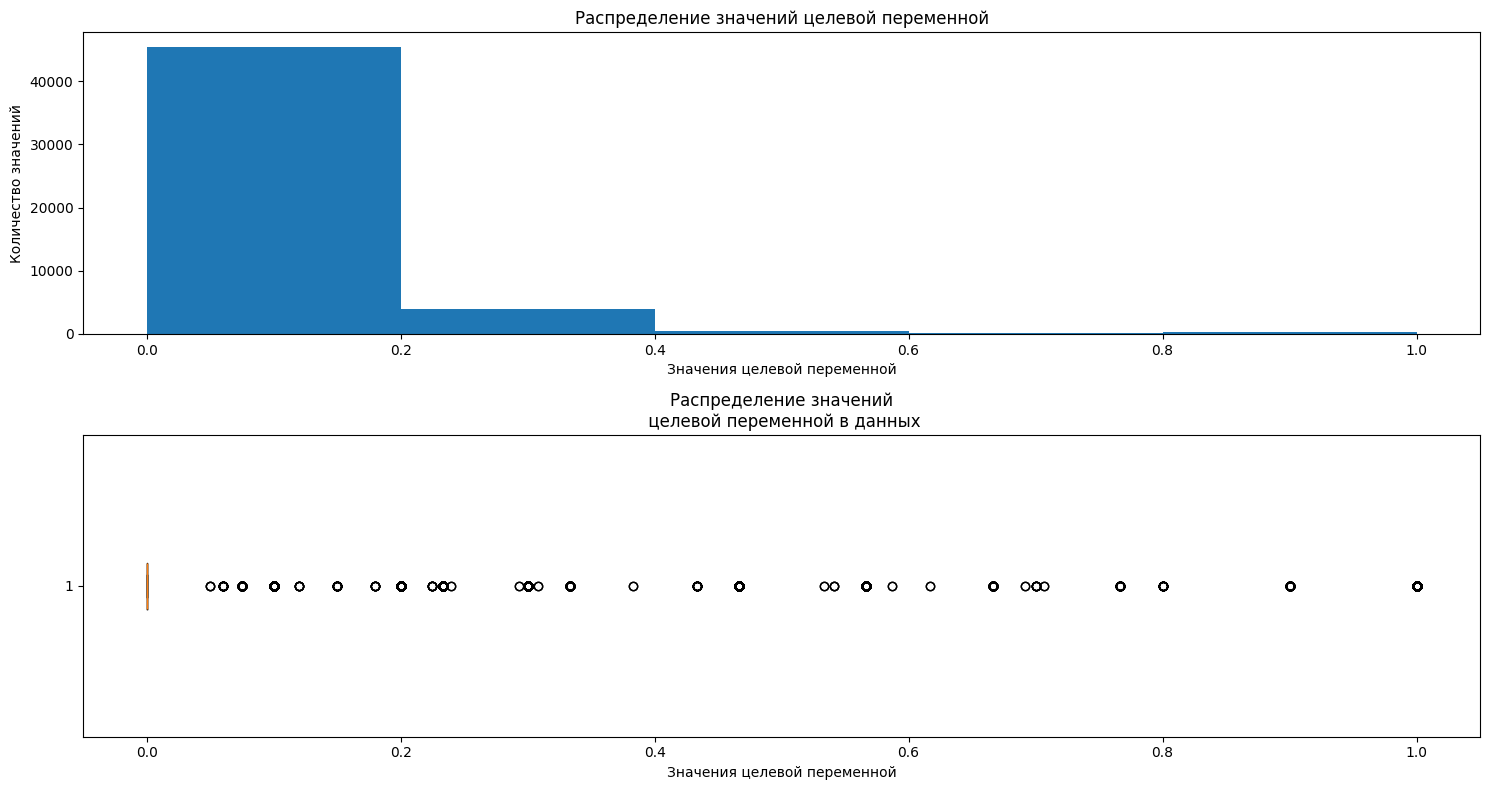

In [33]:
fig, ax = plt.subplots(2,1, figsize=(15, 8))
ax[0].hist(train_final['target'], bins=5)
ax[0].set_xlabel('Значения целевой переменной')
ax[0].set_ylabel('Количество значений')
ax[0].set_title('Распределение значений целевой переменной')
ax[1].boxplot(train_final['target'], vert=False)
ax[1].set_xlabel('Значения целевой переменной')
ax[1].set_title('Распределение значений\n целевой переменной в данных')
plt.tight_layout()
plt.show()

В данных большой перекос значений целевой переменной. Большая часть данных приходится на значения от 0 до 0.2, т.е. на очень низкие значения соответствия изображения описанию.

## 2. Проверка данных

В некоторых странах, где работает ваша компания, действуют ограничения по обработке изображений: поисковым сервисам и сервисам, предоставляющим возможность поиска, запрещено без разрешения родителей или законных представителей предоставлять любую информацию, в том числе, но не исключительно тексты, изображения, видео и аудио, содержащие описание, изображение или запись голоса детей. Ребёнком считается любой человек, не достигший 16 лет.

В вашем сервисе строго следуют законам стран, в которых работают. Поэтому при попытке посмотреть изображения, запрещённые законодательством, вместо картинок показывается дисклеймер:

> This image is unavailable in your country in compliance with local laws
>

Однако у вас в PoC нет возможности воспользоваться данным функционалом. Поэтому все изображения, которые нарушают данный закон, нужно удалить из обучающей выборки.

Перед началом фильтрации текста проведем лемматизацию текста для того, чтобы исключить перечисление единственного и множественного числа в словаре.

In [34]:
# перед фильтрацией переведем все буквы в query_text в нижни регистр
train_final['query_text'] = train_final['query_text'].str.lower()

In [35]:
train_final.sample(10)

,image,query_id,query_text,target
18857,2739331794_4ae78f69a0.jpg,2667015110_1670324a33.jpg#2,a young boy is holding a book .,0.000000
22168,2924259848_effb4dcb82.jpg,2289068031_fe26990183.jpg#2,a person is jumping a motorcycle over a pole w...,0.000000
16328,260828892_7925d27865.jpg,2581066814_179d28f306.jpg#2,naked people riding bikes .,0.000000
36227,3436063693_15c8d377a2.jpg,293879742_5fe0ffd894.jpg#2,a dog jumping off a fence and another dog on t...,0.233333
9836,2301525531_edde12d673.jpg,343218198_1ca90e0734.jpg#2,a black dog running in a backyard,0.000000
35282,3399284917_721aefe2a7.jpg,3596131692_91b8a05606.jpg#2,three children in neon colors play soccer whil...,0.000000
1248,1267711451_e2a754b4f8.jpg,3458559770_12cf9f134e.jpg#2,person in blue jacket on a bike on a dirt cour...,0.000000
19249,2774554310_007e980a90.jpg,2204550058_2707d92338.jpg#2,a woman wearing a white glove peers over the c...,0.000000
6798,2120383553_5825333a3f.jpg,2453971388_76616b6a82.jpg#2,two smiling little girls playing in a fountain...,0.000000
9366,2280525192_81911f2b00.jpg,1897025969_0c41688fa6.jpg#2,a black dog bites a white dog while standing o...,0.000000


### Лемматизация текста

Для лемматизации будем использовать библиотеку spacy.

In [36]:
# создаем функцию для лемматизации текста

def lemmatize(text):
    doc = nlp(text)
    return ' '.join([token.lemma_ for token in doc if not token.is_punct and not token.is_space])

In [37]:
tqdm.pandas()
train_final['lemmatized_query_text'] = train_final['query_text'].progress_apply(lemmatize)

100%|██████████| 50214/50214 [06:44<00:00, 124.00it/s]


In [38]:
train_final.sample(20)

,image,query_id,query_text,target,lemmatized_query_text
25083,3047264346_e24601bfbf.jpg,3544793763_b38546a5e8.jpg#2,a man wearing black boxing shorts and white bo...,0.000000,a man wear black boxing short and white boxing...
38079,3498997518_c2b16f0a0e.jpg,3053743109_a2d780c0d2.jpg#2,a group of basketball players jump in the air ...,0.000000,a group of basketball player jump in the air f...
46782,473220329_819a913bbb.jpg,1267711451_e2a754b4f8.jpg#2,a black and white dog walking through the gras...,0.000000,a black and white dog walk through the grass w...
34298,3364151356_eecd07a23e.jpg,3482974845_db4f16befa.jpg#2,two dogs run across the barren ground .,0.000000,two dog run across the barren ground
6568,2103568100_5d018c495b.jpg,2310126952_7dc86d88f6.jpg#2,a sled dog team running from the perspective o...,0.000000,a sle dog team run from the perspective of the...
10313,2339106348_2df90aa6a9.jpg,3741827382_71e93298d0.jpg#2,a young boy jumps around on a blue mat with a ...,0.000000,a young boy jump around on a blue mat with a h...
20638,2866254827_9a8f592017.jpg,583174725_6b522b621f.jpg#2,a little girl jumps rope through a parking lot,0.000000,a little girl jump rope through a parking lot
26670,3113322995_13781860f2.jpg,422763475_0bc814dac6.jpg#2,a child running with a snowboard on a snow cov...,0.000000,a child run with a snowboard on a snow cover s...
43603,3692892751_f6574e2700.jpg,2878190821_6e4e03dc5f.jpg#2,a young child with a dirty shirt is standing o...,0.000000,a young child with a dirty shirt be stand on a...
3134,1461667284_041c8a2475.jpg,1536774449_e16b1b6382.jpg#2,a crowd of people at an outdoor event,0.433333,a crowd of people at an outdoor event


Приступим к фильтрации. Создадим словарь. Далее проверим содержимое текстов. Важно учесть, что одному изображению может соответствовать несколько описаний.

In [39]:
# создадим словарь, по которому будет происходить фильтрация описания изображения
keywords_dic = {
    'baby',
    'toddler',
    'child',
    'children',
    'childhood',
    'kid',
    'teenager',
    'adolescent',
    'newborn',
    'infant',
    'girl',
    'boy'
}

In [40]:
# создаем функцию для проверки слов в строке на соответствие словарю
def keywords_check(text, keywords):
    words = set(text.split())
    return not words.isdisjoint(keywords)

In [41]:
# сделаем копию таблице для того, чтобы было проще отстраивать код
train_final_2 = train_final.copy()

In [42]:
# находим строки с запрещенными словами
train_final_2['with_ban_keyword'] = train_final_2['lemmatized_query_text'].apply(lambda x: keywords_check(x, keywords_dic))

In [43]:
# находим все id, для которых есть запрещенные слова
query_ids_with_ban_keywords = train_final_2.loc[train_final_2['with_ban_keyword'], 'query_id'].unique()

In [44]:
# удаляем строки связанные с этим id
train_ban = train_final_2[train_final_2['query_id'].isin(query_ids_with_ban_keywords)]

In [45]:
train_ban.head()

,image,query_id,query_text,target,lemmatized_query_text,with_ban_keyword
1,1056338697_4f7d7ce270.jpg,114051287_dd85625a04.jpg#2,a boy in glasses is wearing a red shirt .,0.0,a boy in glass be wear a red shirt,True
2,1056338697_4f7d7ce270.jpg,1427391496_ea512cbe7f.jpg#2,a young boy holds onto a blue handle on a pier .,0.0,a young boy hold onto a blue handle on a pier,True
10,1056338697_4f7d7ce270.jpg,2436081047_bca044c1d3.jpg#2,a little girl wearing a pink shirt jumps off a...,0.0,a little girl wear a pink shirt jump off a swing,True
11,1056338697_4f7d7ce270.jpg,2490768374_45d94fc658.jpg#2,a young girl wearing blue smiles .,0.1,a young girl wear blue smile,True
12,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,a young child is wearing blue goggles and sitt...,0.0,a young child be wear blue goggle and sit in a...,True


In [46]:
# удаляем два последних символа, чтобы получить название рисунка
train_ban['query_id'] = train_ban['query_id'].map(lambda x: str(x)[:-2])
# создаем список запрещенных картинок, которые нужно удалить
ban_images = train_ban['query_id'].unique()

<ipython-input-46-55e42db4cade>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_ban['query_id'] = train_ban['query_id'].map(lambda x: str(x)[:-2])


In [47]:
# вычищаем изображения
train_clear = train_final_2[train_final_2['image'].isin(ban_images) == False]

In [48]:
train_clear.info()

<class 'pandas.core.frame.DataFrame'>
Index: 35842 entries, 0 to 51322
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   image                  35842 non-null  object 
 1   query_id               35842 non-null  object 
 2   query_text             35842 non-null  object 
 3   target                 35842 non-null  float64
 4   lemmatized_query_text  35842 non-null  object 
 5   with_ban_keyword       35842 non-null  bool   
dtypes: bool(1), float64(1), object(4)
memory usage: 1.7+ MB


In [49]:
# удалим лишние столбцы
train_clear.drop(columns=['with_ban_keyword', 'query_text'], inplace=True)

<ipython-input-49-becf693eff66>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_clear.drop(columns=['with_ban_keyword', 'query_text'], inplace=True)


In [50]:
train_clear.info()

<class 'pandas.core.frame.DataFrame'>
Index: 35842 entries, 0 to 51322
Data columns (total 4 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   image                  35842 non-null  object 
 1   query_id               35842 non-null  object 
 2   target                 35842 non-null  float64
 3   lemmatized_query_text  35842 non-null  object 
dtypes: float64(1), object(3)
memory usage: 1.4+ MB


In [51]:
train_clear.sample(10)

,image,query_id,target,lemmatized_query_text
16911,2644430445_47c985a2ee.jpg,3245460937_2710a82709.jpg#2,0.0,a child jump on a tennis court
11973,2431470169_0eeba7d602.jpg,2764178773_d63b502812.jpg#2,0.0,a man be attempt a stunt with a bicycle
12702,246055693_ccb69ac5c6.jpg,2945036454_280fa5b29f.jpg#2,0.0,a yellow dog chase a red frisbee next to a bla...
32354,3285993030_87b0f1d202.jpg,3482974845_db4f16befa.jpg#2,0.0,two dog run across the barren ground
4716,1772859261_236c09b861.jpg,2345984157_724823b1e4.jpg#2,0.1,a brown dog shake off water
4264,1659358141_0433c9bf99.jpg,359837950_9e22ffe6c2.jpg#2,0.0,a black dog walk along a rocky terrain
9580,2289068031_fe26990183.jpg,3263395801_5e4cee2b9e.jpg#2,0.1,a motocross bike be be ride along a woodland path
46606,468102269_135938e209.jpg,2453971388_76616b6a82.jpg#2,0.0,two smile little girl play in a fountain with ...
9396,2280525192_81911f2b00.jpg,3009644534_992e9ea2a7.jpg#2,0.0,a dog fetch a ball in a field
42433,3630641436_8f9ac5b9b2.jpg,3185409663_95f6b958d8.jpg#2,0.0,a little girl run on the wet sand near the ocean


In [52]:
train_clear['image'].nunique()

710

После фильтрации данных в таблице осталось 35842 значения. Пропущенных значений нет.
Текст лемматизирован.
Осталось 710 уникальных изображений из 1000.
Далее можно приступать к векторизации изображений и текстов.

## 3. Векторизация изображений

Перейдём к векторизации изображений.

Самый примитивный способ — прочесть изображение и превратить полученную матрицу в вектор. Такой способ нам не подходит: длина векторов может быть сильно разной, так как размеры изображений разные. Поэтому стоит обратиться к свёрточным сетям: они позволяют "выделить" главные компоненты изображений. Как это сделать? Нужно выбрать какую-либо архитектуру, например ResNet-18, посмотреть на слои и исключить полносвязные слои, которые отвечают за конечное предсказание. При этом можно загрузить модель данной архитектуры, предварительно натренированную на датасете ImageNet.

Воспользуемся советом и будем использовать ResNet-18, при этом оставляем слои модели до последнего классификатора, это должно дать на выходе вектор размерность 512.  
Кроме того, так как у нас всего 710 уникальных изображений, нет смысла векторизовать все 30 тыс.

In [53]:
def get_image_embeddings(image_paths, image_folder):
    # Загрузка модели ResNet18
    resnet18 = models.resnet18(pretrained=True)
    for param in resnet18.parameters():
        param.requires_grad_(False)  # Замораживаем веса

    # Оставляем только части модели до последнего полносвязного слоя
    # Мы будем использовать последний слой перед слоем классификации
    resnet18 = nn.Sequential(*list(resnet18.children())[:-1])  # Убираем последний слой
    resnet18.eval()  # Переводим в режим предсказания

    # Препроцессинг
    norm = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        norm,
    ])

    embeddings = {}
    unique_images = set(image_paths)  # Получаем уникальные изображения

    # Проходим по всем уникальным изображениям
    for filename in tqdm(unique_images):
        # Загружаем и обрабатываем изображение
        path = os.path.join(image_folder, filename)
        img = Image.open(path).convert('RGB')
        image_tensor = preprocess(img).unsqueeze(0)  # Добавляем batch dimension

        with torch.no_grad():
            output_tensor = resnet18(image_tensor)  # Получаем эмбеддинг до полносвязных слоёв
            output_tensor = output_tensor.flatten()  # Делаем выравнивание

        embeddings[filename] = output_tensor.numpy()

    # Преобразуем эмбеддинги обратно в массив для всех изображений в списке
    all_embeddings = []
    for filename in image_paths:
        all_embeddings.append(embeddings[filename])

    all_embeddings = np.stack(all_embeddings)

    return all_embeddings

In [54]:
# Путь к папке с изображениями
image_path = "dataset/to_upload/train_images"
# Получаем эмбеддинги для всех изображений из столбца 'image' в train_clean
image_embeddings = get_image_embeddings(train_clear['image'], image_path)

# Размерность эмбеддингов
image_embeddings.shape

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 169MB/s]
100%|██████████| 710/710 [01:13<00:00,  9.62it/s]


(35842, 512)

## 4. Векторизация текстов

Следующий этап — векторизация текстов. Вы можете поэкспериментировать с несколькими способами векторизации текстов:

tf-idf
word2vec
*трансформеры (например Bert)
* — если вы изучали трансформеры в спринте Машинное обучение для текстов.

Так как я уже начал использовать библиотеку spacy для лемматизации текста, воспользуемся этой же библиотекой для векторизации лемматизированного текста.

In [55]:
# функция для векторизации текста
def vectorize_text(text):
  doc = nlp(text)
  return doc.vector

In [56]:
tqdm.pandas()
train_clear['text_vector'] = train_clear['lemmatized_query_text'].progress_apply(vectorize_text)
text_embeddings = np.vstack(train_clear['text_vector'].values)

100%|██████████| 35842/35842 [04:46<00:00, 125.25it/s]
<ipython-input-56-5df63ce6e42a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_clear['text_vector'] = train_clear['lemmatized_query_text'].progress_apply(vectorize_text)


In [57]:
len(text_embeddings)

35842

In [58]:
len(text_embeddings[0])

300

Для текстов получены вектора размерностью 300.

## 5. Объединение данных для подачи в модель

In [59]:
X = np.concatenate([image_embeddings, text_embeddings], axis=1)
y = train_clear['target'].values

In [60]:
# проверим типы
print(type(X))
print(type(y))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [61]:
# проверим размерности
print(X.shape)
print(y.shape)

(35842, 812)
(35842,)


## 6. Обучение модели предсказания соответствия

Для обучения разделите датасет на тренировочную и тестовую выборки. Простое случайное разбиение не подходит: нужно исключить попадание изображения и в обучающую, и в тестовую выборки.
Для того чтобы учесть изображения при разбиении, можно воспользоваться классом [GroupShuffleSplit](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GroupShuffleSplit.html) из библиотеки sklearn.model_selection.

Код ниже разбивает датасет на тренировочную и тестовую выборки в пропорции 7:3 так, что строки с одинаковым значением 'group_column' будут содержаться либо в тестовом, либо в тренировочном датасете.

```
from sklearn.model_selection import GroupShuffleSplit
gss = GroupShuffleSplit(n_splits=1, train_size=.7, random_state=42)
train_indices, test_indices = next(gss.split(X=df.drop(columns=['target']), y=df['target'], groups=df['group_column']))
train_df, test_df = df.loc[train_indices], df.loc[test_indices]

```

Какую модель использовать — выберите самостоятельно. Также вам предстоит выбрать метрику качества либо реализовать свою.

В данном случае обучение модели подразумевает решение задачи регрессии. Наиболее подходящими метриками могут послужить RMSE, MAE, MSE, R^2. Будем использовать RMSE, что покажет, насколько сильно предсказанные вероятности модели отклоняются от истинных.  
При разделении данных будем использовать GroupShuffleSplit. Правда у такого способа есть минус, при разбиении он не учитывает перекос целевой переменной в сторону низких значений.   
Протестируем несколько моделей. Начнем с построения pipeline для более простых моделей, используя перебор гиперпараметров и обучение на кроссвалидации. После этого обучим нейронную сеть.
Будем использовать следующие модели:  
LinearRegression.  
SVR.  
DecisionTreeRegressor.  
LGBMRegressor

In [62]:
RANDOM_STATE = 42
# разобъем данные на тестовую и валидационную выборки
gss = GroupShuffleSplit(n_splits=1, train_size=0.7, random_state=RANDOM_STATE)
train_indices, val_indices = next(gss.split(X, y, groups=train_clear['image'].values))
X_train, X_val = X[train_indices], X[val_indices]
y_train, y_val = y[train_indices], y[val_indices]

Перед построением pipeline и перебора гиперпараметров проверим, какой результат покажет базовая модель DummyRegressor, стратегию заполнения медианой. Данная стратегия выбрана, так как в распределении целевой переменной явный перекос в сторону низких значений.

In [63]:
dummy_regressor = DummyRegressor(strategy='median')

In [64]:
dummy_regressor.fit(X_train, y_train)
y_pred = dummy_regressor.predict(X_val)
rmse = root_mean_squared_error(y_val, y_pred)
print(rmse)

0.12986267056348602


Значение RMSE на dummy модели составляет 0.129, т.е. модель в своей оценке ошибается на 0.129.
Таким образом, нам необходимо, чтобы более сложные модели показали значения ниже 0.129.

Перейдем к построению более сложных моделей.

In [65]:
# создаем пайалайн
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('models', LinearRegression())
])
# создаем словари для моделей
param_grid = [
    {
        'models': [LinearRegression()]

    },
    {
        'models': [SVR()],
        'models__kernel': ['rbf'],
        'models__C': [1, 5]
   },
   {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth':[5, 10, 20],
        'models__min_samples_split': [10, 50, 100]
   },
   {
        'models':[LGBMRegressor(random_state=RANDOM_STATE)],
        'models__num_leaves': [30, 60],
        'models__max_depth': [8, 12],
        'models__learning_rate': [0.05, 0.1],
   }
]

grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,
    scoring ='neg_root_mean_squared_error',
    n_jobs=-1,
    verbose=2,
    error_score='raise'
)
grid_search.fit(X_train, y_train)

print('Лучшая модель и её параметры:\n\n', grid_search.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', grid_search.best_score_)
print('Лучшие гиперпараметры модели:', grid_search.best_params_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.572695 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 204732
[LightGBM] [Info] Number of data points in the train set: 25276, number of used features: 812
[LightGBM] [Info] Start training from score 0.040284
Лучшая модель и её параметры:

 Pipeline(steps=[('scaler', StandardScaler()),
                ('models',
                 LGBMRegressor(learning_rate=0.05, max_depth=12, num_leaves=60,
                               random_state=42))])
Метрика лучшей модели на тренировочной выборке: -0.11555311559977106
Лучшие гиперпараметры модели: {'models': LGBMRegressor(random_state=42), 'models__learning_rate': 0.05, 'models__max_depth': 12, 'models__num_leaves': 60}


In [66]:
model_result = pd.DataFrame(grid_search.cv_results_)
model_result['model'] = model_result['param_models'].apply(lambda x: str(x).split('(')[0])
results_by_model = model_result.groupby('model').agg({
    'mean_test_score': 'max',
    'params': 'first'
}).reset_index().sort_values(by='mean_test_score', ascending=False)
results_by_model

,model,mean_test_score,params
1,LGBMRegressor,-0.115553,"{'models': LGBMRegressor(random_state=42), 'mo..."
0,DecisionTreeRegressor,-0.121099,{'models': DecisionTreeRegressor(random_state=...
3,SVR,-0.121123,"{'models': SVR(), 'models__C': 1, 'models__ker..."
2,LinearRegression,-0.125793,{'models': LinearRegression()}


Лучший результат на кросс-валидации показала модель LGBMRegressor, значение метрики составило 0.115, что незначительно лучше базовой модели.

Проверим лучшую модель на валидационной выборке

In [68]:
y_val_pred = grid_search.best_estimator_.predict(X_val)
RMSE = root_mean_squared_error(y_val, y_val_pred)
print(RMSE)

0.11804208331463255


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


На валидационной выборке лучшая модель показала результат 0.118. Результат почти совпадает с результатом на кросс-валидации

## Модель нейронной сети
Далее разработаем модель нейронной сети. Для организации модели будем использовать библиотеку keras.

In [73]:
# перед обучением отмасштабируем данные.
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

In [75]:
tf.random.set_seed(RANDOM_STATE)
# создаем модель
neural_n = Sequential()
# первый слой
neural_n.add(Dense(1024, input_shape=(X.shape[1],), activation='relu'))
# нормализация
neural_n.add(BatchNormalization())
# второй слой
neural_n.add(Dense(256, activation='relu'))
# нормализация
neural_n.add(BatchNormalization())
# последний слой с одним выводом так как регрессия + ReLU убираем отрицательные значения в предсказаниях
neural_n.add(Dense(1, activation='relu'))

neural_n.compile(optimizer = Adam(learning_rate = 0.0001),
              loss='mean_squared_error',
              metrics=[RootMeanSquaredError()])
# обучение
neural_n.fit(X_train_scaled,
             y_train,
             validation_data=(X_val_scaled, y_val),
             epochs=50,
             batch_size=32,
             verbose=2,
             shuffle=True)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
790/790 - 17s - 22ms/step - loss: 0.1079 - root_mean_squared_error: 0.3285 - val_loss: 0.0377 - val_root_mean_squared_error: 0.1942
Epoch 2/50
790/790 - 20s - 25ms/step - loss: 0.0179 - root_mean_squared_error: 0.1338 - val_loss: 0.0246 - val_root_mean_squared_error: 0.1568
Epoch 3/50
790/790 - 20s - 26ms/step - loss: 0.0153 - root_mean_squared_error: 0.1238 - val_loss: 0.0239 - val_root_mean_squared_error: 0.1545
Epoch 4/50
790/790 - 14s - 18ms/step - loss: 0.0174 - root_mean_squared_error: 0.1318 - val_loss: 0.0187 - val_root_mean_squared_error: 0.1367
Epoch 5/50
790/790 - 14s - 18ms/step - loss: 0.0163 - root_mean_squared_error: 0.1276 - val_loss: 0.0177 - val_root_mean_squared_error: 0.1332
Epoch 6/50
790/790 - 20s - 25ms/step - loss: 0.0169 - root_mean_squared_error: 0.1300 - val_loss: 0.0172 - val_root_mean_squared_error: 0.1313
Epoch 7/50
790/790 - 15s - 19ms/step - loss: 0.0170 - root_mean_squared_error: 0.1303 - val_loss: 0.0174 - val_root_mean_squared_error: 0.1319

Нейронная модель, по-видимому, достигла локального минимума. Начиная с 11 эпохи метрика качества не меняется. На обучающей выборке модель достигла значения 0.0161, в то время как на валидационной выборке значение составило 0.129, что сопоставимо с базовой моделью.

## Вывод:
Было протестировано 5 моделей:  
* LinearRegression  
* SVR  
* DecisionTreeRegressor  
* LGBMRegressor
* Нейронная сеть
Лучший результат на валидационной выборке показала модель LGBMRegressor, значение метрики составило 0.115, что лучше базовой модели.
Для тестирования будем использовать эту модель.


## 7. Тестирование модели

Настало время протестировать модель. Для этого получите эмбеддинги для всех тестовых изображений из папки `test_images`, выберите случайные 10 запросов из файла `test_queries.csv` и для каждого запроса выведите наиболее релевантное изображение. Сравните визуально качество поиска.  

Предсказания на тесте будем получать, используя лучшую модель - LGBMRegressor.
Данные с тестовой выборкой были загружены ранее в переменную test_df.  
Преобразуем в векторное представление тестовые изображения.  
Лемматизируем описание в тестовой выборке.  
Создадим функцию, которая будет дополнительно векторизовать текст, далее соберет все признаки вместе и сделает предсказания, используя grid_search.best_estimator_.  
Полученные предсказания будут добавлены в таблицу с тестовыми данными.
Далее будет сделана функция, которая отберет 10 случайных текстов, найдет для них максимальное значения предсказания и покажет соответствующие изображение.


In [76]:
# Лемматизируем текст из тестовой выборки
tqdm.pandas()
test_df['lemmatized_query_text'] = test_df['query_text'].progress_apply(lemmatize)

100%|██████████| 500/500 [00:04<00:00, 114.41it/s]


In [79]:
# Векторизуем изображения
test_image_path = "dataset/to_upload/test_images"
test_image_embeddings = get_image_embeddings(test_df['image'], test_image_path)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 100/100 [00:12<00:00,  7.70it/s]


In [80]:
test_image_embeddings.shape

(500, 512)

'dataset/to_upload/test_images'

In [106]:
def get_relevant_images(test_queries, test_image_embeddings):
  # Преобразуем Series в список строк
  test_queries_list = test_queries['lemmatized_query_text'].tolist()

  # Векторизуем текст
  test_text_v = [vectorize_text(query) for query in test_queries_list]

  # Преобразуем список в массив
  test_text_embeddings = np.vstack(test_text_v)

  # Объединяем векторы изображения и текста
  X_test = np.concatenate([test_image_embeddings, test_text_embeddings], axis=1)

  # Делаем предсказания
  y_test_pred = grid_search.best_estimator_.predict(X_test)

  # Создаем DataFrame для результатов
  results = test_queries.copy()  # Восстанавливаем DataFrame, если test_queries был DataFrame.
  results['prediction'] = y_test_pred  # Добавляем предсказания
  return results

In [107]:
results = get_relevant_images(test_df, test_image_embeddings)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [108]:
results.head()

,Unnamed: 0,query_id,query_text,image,lemmatized_query_text,text_vector,prediction
0,0,1177994172_10d143cb8d.jpg#0,"Two blonde boys , one in a camouflage shirt an...",1177994172_10d143cb8d.jpg,two blonde boy one in a camouflage shirt and t...,"[-0.69354993, 0.020384993, -0.22612794, 0.0899...",0.009833
1,1,1177994172_10d143cb8d.jpg#1,Two boys are squirting water guns at each other .,1177994172_10d143cb8d.jpg,two boy be squirt water gun at each other,"[-0.67331666, 0.038685557, -0.060986444, 0.088...",0.006477
2,2,1177994172_10d143cb8d.jpg#2,Two boys spraying each other with water,1177994172_10d143cb8d.jpg,two boy spray each other with water,"[-0.6557272, 0.011601431, -0.20236202, -0.0465...",0.036494
3,3,1177994172_10d143cb8d.jpg#3,Two children wearing jeans squirt water at eac...,1177994172_10d143cb8d.jpg,two child wear jean squirt water at each other,"[-0.70431995, 0.15901223, 0.0030713337, -0.032...",0.032647
4,4,1177994172_10d143cb8d.jpg#4,Two young boys are squirting water at each oth...,1177994172_10d143cb8d.jpg,two young boy be squirt water at each other,"[-0.6844522, 0.077982225, -0.18105534, 0.11443...",0.004396


In [124]:
results.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Unnamed: 0             500 non-null    int64  
 1   query_id               500 non-null    object 
 2   query_text             500 non-null    object 
 3   image                  500 non-null    object 
 4   lemmatized_query_text  500 non-null    object 
 5   text_vector            500 non-null    object 
 6   prediction             500 non-null    float64
dtypes: float64(1), int64(1), object(5)
memory usage: 27.5+ KB


Мы получили предсказания для всех пар изображений и текстов. Выберем 10 случайных запросов из query_text и найдем для каждого из них изображение с максимальным prediction.

In [134]:
def show_top_images_for_queries(results_df, image_dir, banned_words, top_n=10):
    # Выбираем 10 случайных уникальных текстов
    sampled_queries = results_df['query_text'].sample(top_n).unique()

    # Отбираем лучшие предсказания для каждого из них
    top_rows = []
    for query in sampled_queries:
        subset = results_df[results_df['query_text'] == query]
        top_row = subset.loc[subset['prediction'].idxmax()]
        top_rows.append(top_row)

    # Визуализация
    plt.figure(figsize=(15, 10))
    for idx, row in enumerate(top_rows):
        plt.subplot(2, 5, idx + 1)

        is_banned = any(banned in row['lemmatized_query_text'].split() for banned in banned_words)

        if is_banned:
            # Заглушка
            plt.text(0.5, 0.5,
                     'This image is unavailable\nin your country\nin compliance with local laws.',
                     ha='center', va='center', fontsize=8, wrap=True)
            plt.axis('off')
        else:
            # Путь к изображению
            img_path = os.path.join(image_dir, row['image'])
            img = mpimg.imread(img_path)
            plt.imshow(img)
            plt.axis('off')

        # Заголовок
        plt.title(f"{row['prediction']:.2f}\n{row['query_text'][:40]}...", fontsize=8)

    plt.tight_layout()
    plt.show()

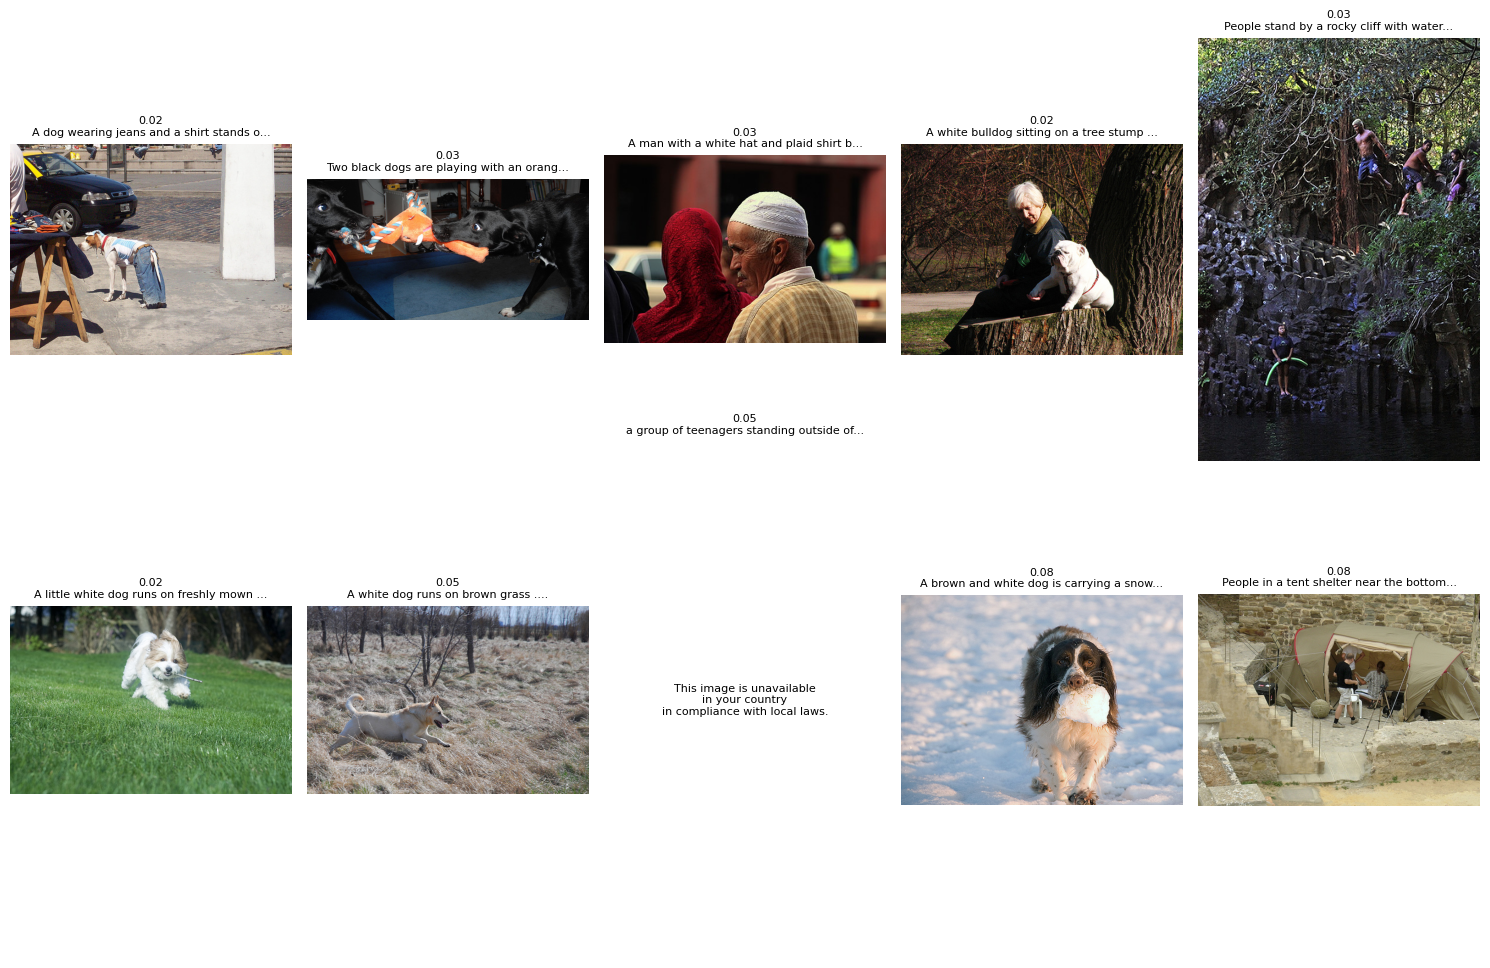

In [135]:
show_top_images_for_queries(results, test_image_path, keywords_dic, top_n=10)

Получили десять текстов и изображения к ним с максимальным предсказанием. К сожалению, модель работает не так хорошо, как бы хотелось. Везде достаточно низкие значения предсказания, независимо от того, что изображено на картинке. Фильтрация для слов работает корректно.

## Вывод:
В процессе подготовки проекта было сделано следующие:  
* Первичный анализ данных показал явный перекос в сторону оценок, полученных за счёт краудсорсинга.
* Была выполнена агрегация и нормализация оценок экспертов. Использовали медианное значение и минимум-максимум нормализацию.
* Для оценок краудсорсинга использовали значение доли людей подтвердивших, что описание соответствует изображению.
* При объединении таблиц было принято решение сохранить все типы оценок.
* Для создания целевой переменной больший вес был дан экспертной оценки, так как данная оценка вызывает больше доверия.

Была обнаружена первая существенная проблема в данных – перекос распределения целевой переменной. Т.е. очень мало оценок хорошего соответствия изображения описанию.  

Обязательным условием было отфильтровать изображения, на которых есть дети. Для этого был создан словарь, фильтрация происходила уже после лемматизации текста.
После фильтрации в данных осталась 710 уникальных изображений, против 1000 изначальных.

Для векторизации изображений использовали ResNet-18.
Для векторизации текстов SpaCY.

Было взято пять моделей для обучения. В качестве метрики использовали RMSE.
Лучший результат показала модель LGBMRegressor, RMSE = 0.118, при этом базовая модель показывает результат 0.129. Таким образом, разрыв между моделями минимален.

Тестирование модели показало очень посредственный результат. Визуальный анализ качества поиска показывает, что модель дает очень низкие значения оценки, как изображениям, не соответствующим описанию, так и наоборот.

Основные проблемы и способы решения:  
* Очень большой перекос в количестве данных в сторону оценок краудсорсинга. Способ решения:
Обучить модель только на оценках экспертов. Или сделать одинаковые выборки оценок экспертов и краудсорсинга, т.е. включить в модель только те описания, для которых есть оценки в обоих группах.
* Малое количество оценок, которые указывали бы на хорошее соответствие изображения тексту. Возможно, решается работой только с оценками экспертов.
* Слабая работа нейронной сети.
Возможно, поможет более сложная и глубокая настройка.





- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке исполнения
- [ ]  Исследовательский анализ данных выполнен
- [ ]  Проверены экспертные оценки и краудсорсинговые оценки
- [ ]  Из датасета исключены те объекты, которые выходят за рамки юридических ограничений
- [ ]  Изображения векторизованы
- [ ]  Текстовые запросы векторизованы
- [ ]  Данные корректно разбиты на тренировочную и тестовую выборки
- [ ]  Предложена метрика качества работы модели
- [ ]  Предложена модель схожести изображений и текстового запроса
- [ ]  Модель обучена
- [ ]  По итогам обучения модели сделаны выводы
- [ ]  Проведено тестирование работы модели
- [ ]  По итогам тестирования визуально сравнили качество поиска